# Diffuse on Gaussian Mixtures    

Gaussian Mixture Models (GMM) have the advangtage of admitting closed form solution for the diffusion processes and the for the posterior sampling task of inverse problems. In this Tutorial we will show how to use Gaussian Mixtures to test Diffuse and illustrate its core components.

## Gaussian Mixture Model (GMM)

A GMM represents a probability distribution as a weighted sum of $K$ Gaussian components:

$$p(x)=\sum_{i=1}^Kw_i\mathcal{N}(x;\mu_i,\Sigma_i)$$

Where:
- $w_i\geq0$, $\sum_iw_i=1$ (mixture weights)
- $\mu_i\in\mathbb{R}^d$ (component means)
- $\Sigma_i\in\mathbb{R}^{d\times d}$ (component covariance matrices)

In the following, we introduce the helper functions :code:`MixState` and :code:`pdf_mixtr` to create and evaluate GMMs, and :code:`sampler_mixtr` to sample from them.

In [27]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from myst_nb import glue

# Import GMM utilities
from diffuse.examples.gaussian_mixtures.mixture import MixState, pdf_mixtr, sampler_mixtr
from diffuse.examples.gaussian_mixtures.initialization import init_simple_mixture

# Set random seed
key = jax.random.PRNGKey(42)

# Create 1D mixture
key, subkey = jax.random.split(key)
mix_state_1d = init_simple_mixture(subkey, d=1, n_components=3)

# Create 2D mixture by hand for clarity
weights = jnp.array([0.6, 0.4])
means = jnp.array([[0.0, 0.0], [2.0, 2.0]])
covariances = jnp.array([jnp.eye(2) * 0.5, jnp.eye(2) * 0.8])
mix_state = MixState(weights=weights, means=means, covariances=covariances)

# Sample from 1D mixture
key, subkey = jax.random.split(key)
samples_1d = sampler_mixtr(subkey, mix_state_1d, 500)

# Sample from 2D mixture
key, subkey = jax.random.split(key)
samples = sampler_mixtr(subkey, mix_state, 500)

print(f"Created 1D and 2D GMMs")
print(f"Sampled {len(samples_1d)} 1D points and {len(samples)} 2D points")

# Create PDF grid for 2D
x_range = jnp.linspace(-2, 4, 50)
y_range = jnp.linspace(-2, 4, 50)
X, Y = jnp.meshgrid(x_range, y_range)
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=1)

def pdf(x):
    return pdf_mixtr(mix_state, x)

# Evaluate PDF on grid
pdf_values = jax.vmap(pdf)(grid_points)
pdf_grid = pdf_values.reshape(X.shape)

Created 1D and 2D GMMs
Sampled 500 1D points and 500 2D points


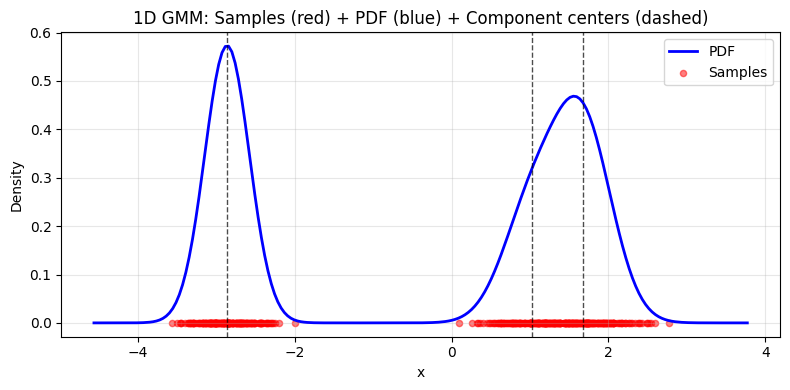

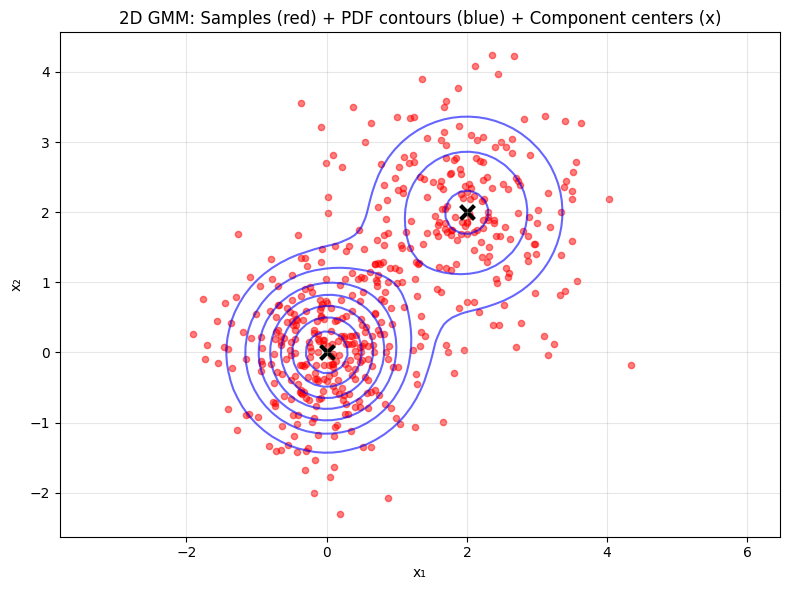

In [28]:
# Plot 1D samples with PDF
fig = plt.figure(figsize=(8, 4))
x_1d_range = jnp.linspace(samples_1d.min() - 1, samples_1d.max() + 1, 200)
# Use manual loop to avoid vmap issues with MixState
pdf_1d_values = jnp.array([pdf_mixtr(mix_state_1d, jnp.array([x_val])) for x_val in x_1d_range])

plt.plot(x_1d_range, pdf_1d_values, 'b-', linewidth=2, label='PDF')
plt.scatter(samples_1d.flatten(), jnp.zeros_like(samples_1d.flatten()), alpha=0.5, s=20, c='red', label='Samples')
for mean in mix_state_1d.means.flatten():
    plt.axvline(mean, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('1D GMM: Samples (red) + PDF (blue) + Component centers (dashed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
glue("gmm_samples_1d", fig, display=False)
plt.show()

# Plot 2D samples with PDF contours
fig = plt.figure(figsize=(8, 6))
plt.contour(X, Y, pdf_grid, levels=8, colors="blue", alpha=0.6, linewidths=1.5)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=20, c="red")
plt.scatter(means[:, 0], means[:, 1], c="black", s=100, marker="x", linewidth=3)
plt.title("2D GMM: Samples (red) + PDF contours (blue) + Component centers (x)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True, alpha=0.3)
plt.axis("equal")
plt.tight_layout()
glue("gmm_samples_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
```{glue} gmm_samples_1d
```
:::

:::{tab-item} 2D
```{glue} gmm_samples_2d
```
:::

::::


## Closed Form Solution

One of the key advantages of GMMs in diffusion modeling is that they admit **closed-form solutions** for both the forward diffusion process and posterior sampling in inverse problems. In this section, we demonstrate:

1. **Forward Diffusion**: How the GMM distribution evolves analytically under the diffusion SDE
2. **Posterior Computation**: How to compute the exact posterior distribution given measurements

### Forward Diffusion Evolution

Given an initial data distribution $x_0 \sim \text{GMM}$, i.e., $p_0(x_0) = \sum_i w_i \mathcal{N}(x_0; \mu_i(0), \Sigma_i(0))$, where $\sum_i w_i = 1$ and $w_i \geq 0$, and a diffusion process defined by $x_t = s(t) x_0 + \sigma(t) \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, I)$, the diffused distribution $p_t(x_t)$ is also a Gaussian Mixture Model (GMM).

The diffused distribution is given by:

$$p_t(x_t) = \sum_i w_i \mathcal{N}(x_t; \mu_i(t), \Sigma_i(t))$$

Where:
- **Mean**: $\mu_i(t) = s(t) \mu_i(0)$
- **Covariance**: $\Sigma_i(t) = s(t)^2 \Sigma_i(0) + \sigma(t)^2 I$
- **Weights**: $w_i(t) = w_i(0)$ (weights remain unchanged)

**Note**: The covariance expression assumes a general diffusion process. In specific diffusion models (e.g., variance-preserving diffusions like DDPM), the noise schedule may define $\sigma(t)^2 = 1 - s(t)^2$, leading to $\Sigma_i(t) = s(t)^2 \Sigma_i(0) + (1 - s(t)^2) I$. 

These transformations are implemented in :code:`transform_mixture_params`. It allows to compute the transformed parameters of the GMM at any time $t$ given the initial parameters and the diffusion process with :code:`transform_mixture_params(mix_state, sde, t)`.


In [29]:
# Import diffusion components
from diffuse.diffusion.sde import LinearSchedule, SDE
from diffuse.examples.gaussian_mixtures.mixture import rho_t, transform_mixture_params

# Create SDE with linear schedule
beta = LinearSchedule(b_min=0.02, b_max=7.0, t0=0.0, T=1.0)
sde = SDE(beta=beta)

# Time evolution from t=0 to t=1
time_points = jnp.array([0.0, 0.3, 0.6, 1.0])
transform_at_times = jax.vmap(lambda t: transform_mixture_params(mix_state, sde, t))
mixtures_at_times = transform_at_times(time_points)

# Sample from all transformed 2D mixtures
keys = jax.random.split(jax.random.PRNGKey(123), len(time_points))
sample_at_times = jax.vmap(lambda k, mix: sampler_mixtr(k, mix, 300))
samples_at_times = sample_at_times(keys, mixtures_at_times)

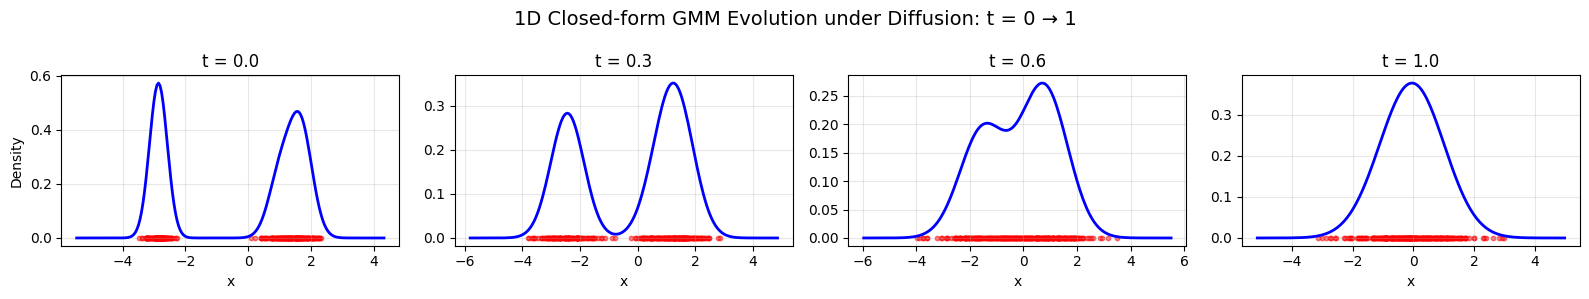

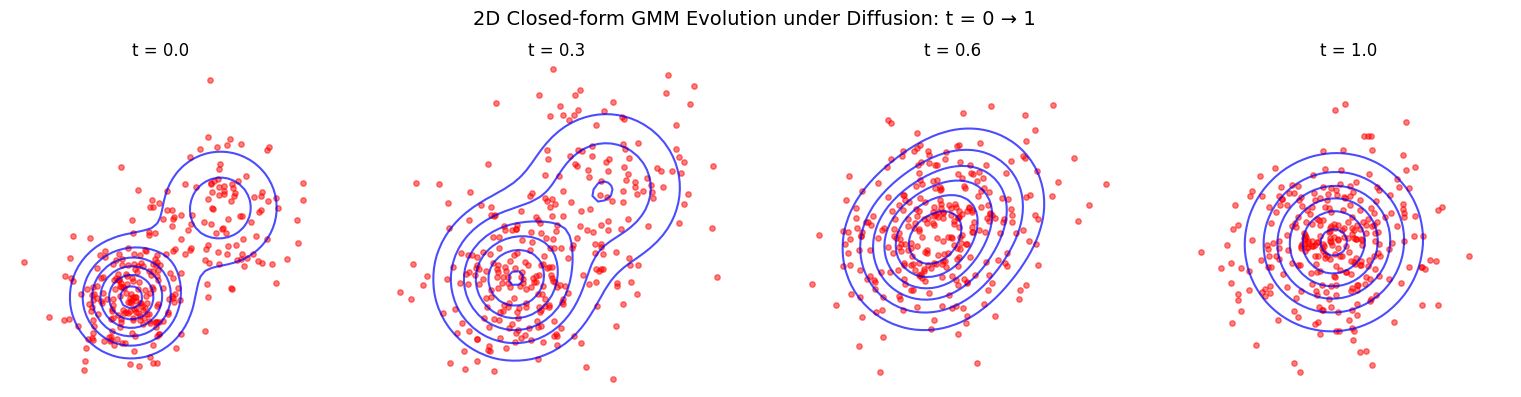

In [30]:
# Evaluate PDF for all 2D mixtures at once
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=1)
evaluate_pdf = jax.vmap(lambda mix: jax.vmap(lambda x: pdf_mixtr(mix, x))(grid_points))
pdf_values_all = evaluate_pdf(mixtures_at_times)  # (n_times, n_grid_points)
pdf_grids = pdf_values_all.reshape(len(time_points), X.shape[0], X.shape[1])
# Transform 1D mixture at all times
transform_at_times_1d = jax.vmap(lambda t: transform_mixture_params(mix_state_1d, sde, t))
mixtures_at_times_1d = transform_at_times_1d(time_points)

# Sample from all transformed 1D mixtures
keys_1d = jax.random.split(jax.random.PRNGKey(123), len(time_points))
sample_at_times_1d = jax.vmap(lambda k, mix: sampler_mixtr(k, mix, 300))
samples_at_times_1d = sample_at_times_1d(keys_1d, mixtures_at_times_1d)
# Create 1D evolution plot
fig, axes = plt.subplots(1, len(time_points), figsize=(16, 3))
fig.suptitle("1D Closed-form GMM Evolution under Diffusion: t = 0 → 1", fontsize=14)

for i, t in enumerate(time_points):
    ax = axes[i]

    # Get current samples
    current_samples = samples_at_times_1d[i]

    # Create PDF for this time point using rho_t directly
    x_range_local = jnp.linspace(current_samples.min() - 2, current_samples.max() + 2, 200)
    # Use rho_t which handles the mixture transformation correctly
    pdf_values = jnp.array([rho_t(jnp.array([x_val]), t, init_mix_state=mix_state_1d, sde=sde) for x_val in x_range_local])

    ax.plot(x_range_local, pdf_values, 'b-', linewidth=2)
    ax.scatter(current_samples.flatten(), jnp.zeros_like(current_samples.flatten()),
               alpha=0.5, s=10, c='red')
    ax.set_title(f"t = {t:.1f}")
    ax.set_xlabel("x")
    if i == 0:
        ax.set_ylabel("Density")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
glue("evolution_1d", fig, display=False)
plt.show()

# Create 2D evolution plot
fig, axes = plt.subplots(1, len(time_points), figsize=(16, 4))
fig.suptitle("2D Closed-form GMM Evolution under Diffusion: t = 0 → 1", fontsize=14)

for i, t in enumerate(time_points):
    ax = axes[i]

    # Plot using pre-computed values
    ax.contour(X, Y, pdf_grids[i], levels=6, colors="blue", alpha=0.7, linewidths=1.5)
    ax.scatter(samples_at_times[i, :, 0], samples_at_times[i, :, 1], alpha=0.5, s=15, c="red")

    ax.set_title(f"t = {t:.1f}")
    ax.set_aspect("equal")
    ax.axis("off")  # Remove axis

    if i == 0:
        ax.set_ylabel("x₂")
    ax.set_xlabel("x₁")

plt.tight_layout()
glue("evolution_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
```{glue} evolution_1d
```
:::

:::{tab-item} 2D
```{glue} evolution_2d
```
:::

::::

### Posterior Computation with Linear Measurements 

Given a prior distribution $x \sim \text{GMM}$, i.e., $p(x) = \sum_i w_i \mathcal{N}(x; \mu_i, \Sigma_i)$, where $\sum_i w_i = 1$, $w_i \geq 0$, and each component has mean $\mu_i$ and covariance matrix $\Sigma_i$, and a measurement model $y = A x + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, \sigma_y^2 I)$, the posterior distribution $p(x|y)$ is also a Gaussian Mixture Model (GMM).

The posterior is given by:

$$p(x|y) = \sum_i \bar{w}_i \mathcal{N}(x; \bar{\mu}_i, \bar{\Sigma}_i)$$

Where:
- **Covariance**: $\bar{\Sigma}_i = \left( \Sigma_i^{-1} + \frac{1}{\sigma_y^2} A^T A \right)^{-1}$
- **Mean**: $\bar{\mu}_i = \bar{\Sigma}_i \left( \frac{1}{\sigma_y^2} A^T y + \Sigma_i^{-1} \mu_i \right)$
- **Weights**: $\bar{w}_i \propto w_i \times p(y|\mu_i, \Sigma_i)$, with normalization $\sum_i \bar{w}_i = 1$
- **Likelihood**: $p(y|\mu_i, \Sigma_i) = \mathcal{N}(y; A \mu_i, A \Sigma_i A^T + \sigma_y^2 I)$

This conjugacy property makes GMMs particularly useful for testing and debugging diffusion-based inverse problems, as the posterior can be computed analytically at each step. In the following, we will compare the closed-form solution obtained with :code:`compute_posterior` with the numerical solution given by the reverse-time SDE and approximate posterior sampling methods.


In [31]:
from diffuse.examples.gaussian_mixtures.cond_mixture import compute_posterior

# 1D measurement setup
A_1d = jnp.array([[1.0]])  # Measure the only coordinate
y_observed_1d = jnp.array([0.5])  # Observed x = 0.5
sigma_y_1d = 0.2

print(f"1D Measurement: y = {y_observed_1d} (observed x = 0.5)")

# Compute 1D posterior
posterior_state_1d = compute_posterior(mix_state_1d, y_observed_1d, A_1d, sigma_y_1d)

# Sample from 1D prior and posterior
key_prior_1d, key_posterior_1d = jax.random.split(jax.random.PRNGKey(789))
prior_samples_1d = sampler_mixtr(key_prior_1d, mix_state_1d, 400)
posterior_samples_1d = sampler_mixtr(key_posterior_1d, posterior_state_1d, 400)

# 2D measurement setup: observe first coordinate
A = jnp.array([[1.0, 0.0]])  # Measure only x[0]
y_observed = jnp.array([1.5])  # Observed x[0] = 1.5
sigma_y = 0.2

print(f"2D Measurement: y = {y_observed} (observed x[0] = 1.5)")

# Compute 2D posterior
posterior_state = compute_posterior(mix_state, y_observed, A, sigma_y)

# Sample from 2D prior and posterior
key_prior, key_posterior = jax.random.split(jax.random.PRNGKey(789))
prior_samples = sampler_mixtr(key_prior, mix_state, 400)
posterior_samples = sampler_mixtr(key_posterior, posterior_state, 400)

# Compute prior PDF for 2D
prior_pdf = jax.vmap(lambda x: pdf_mixtr(mix_state, x))(grid_points)
prior_pdf_grid = prior_pdf.reshape(X.shape)

# Compute posterior PDF for 2D
posterior_pdf = jax.vmap(lambda x: pdf_mixtr(posterior_state, x))(grid_points)
posterior_pdf_grid = posterior_pdf.reshape(X.shape)

1D Measurement: y = [0.5] (observed x = 0.5)
2D Measurement: y = [1.5] (observed x[0] = 1.5)


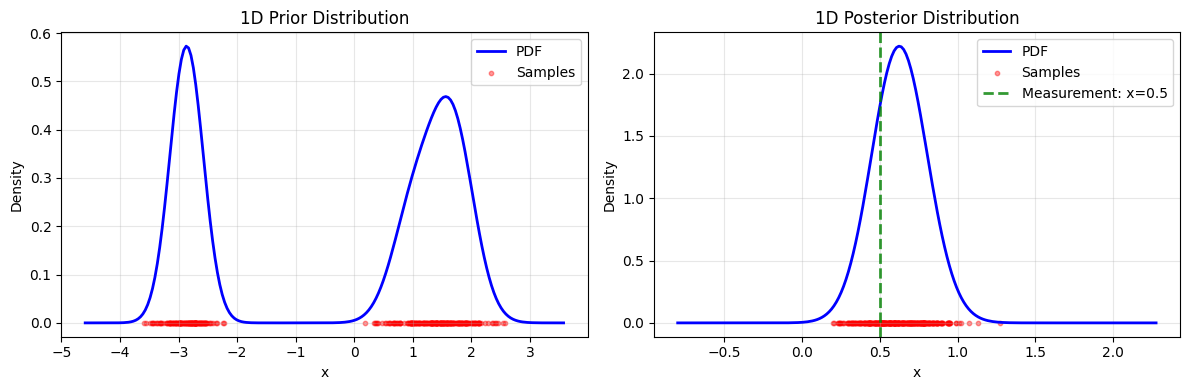

1D Posterior x mean: 0.61 (should be ≈ 0.5)


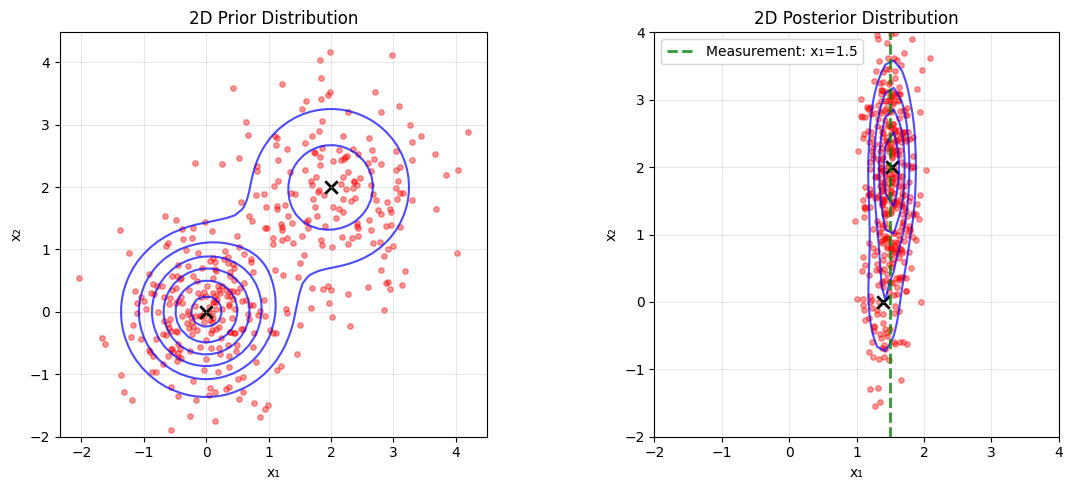

2D Posterior x₁ mean: 1.48 (should be ≈ 1.5)


In [32]:
# Create 1D posterior plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 1D Prior
x_1d_range = jnp.linspace(prior_samples_1d.min() - 1, prior_samples_1d.max() + 1, 200)
prior_pdf_1d = jnp.array([pdf_mixtr(mix_state_1d, jnp.array([x_val])) for x_val in x_1d_range])
ax1.plot(x_1d_range, prior_pdf_1d, 'b-', linewidth=2, label='PDF')
ax1.scatter(prior_samples_1d.flatten(), jnp.zeros_like(prior_samples_1d.flatten()),
            alpha=0.4, s=10, c='red', label='Samples')
ax1.set_title("1D Prior Distribution")
ax1.set_xlabel("x")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 1D Posterior
x_1d_post_range = jnp.linspace(posterior_samples_1d.min() - 1, posterior_samples_1d.max() + 1, 200)
posterior_pdf_1d = jnp.array([pdf_mixtr(posterior_state_1d, jnp.array([x_val])) for x_val in x_1d_post_range])
ax2.plot(x_1d_post_range, posterior_pdf_1d, 'b-', linewidth=2, label='PDF')
ax2.scatter(posterior_samples_1d.flatten(), jnp.zeros_like(posterior_samples_1d.flatten()),
            alpha=0.4, s=10, c='red', label='Samples')
ax2.axvline(x=y_observed_1d[0], color='green', linestyle='--', linewidth=2,
            alpha=0.8, label=f'Measurement: x={y_observed_1d[0]}')
ax2.set_title("1D Posterior Distribution")
ax2.set_xlabel("x")
ax2.set_ylabel("Density")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
glue("posterior_1d", fig, display=False)
plt.show()

print(f"1D Posterior x mean: {jnp.mean(posterior_samples_1d):.2f} (should be ≈ {y_observed_1d[0]})")

# Create 2D posterior plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.contour(X, Y, prior_pdf_grid, levels=6, colors="blue", alpha=0.7, linewidths=1.5)
ax1.scatter(prior_samples[:, 0], prior_samples[:, 1], alpha=0.4, s=15, c="red")
ax1.scatter(mix_state.means[:, 0], mix_state.means[:, 1], c="black", s=80, marker="x", linewidth=2)
ax1.set_title("2D Prior Distribution")
ax1.set_xlabel("x₁")
ax1.set_ylabel("x₂")
ax1.grid(True, alpha=0.3)
ax1.set_aspect("equal")

ax2.contour(X, Y, posterior_pdf_grid, levels=6, colors="blue", alpha=0.7, linewidths=1.5)
ax2.scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.4, s=15, c="red")
ax2.scatter(posterior_state.means[:, 0], posterior_state.means[:, 1], c="black", s=80, marker="x", linewidth=2)
ax2.axvline(x=y_observed[0], color="green", linestyle="--", linewidth=2, alpha=0.8,
            label=f"Measurement: x₁={y_observed[0]}")
ax2.set_title("2D Posterior Distribution")
ax2.set_xlabel("x₁")
ax2.set_ylabel("x₂")
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(-2, 4)
ax2.set_ylim(-2, 4)
ax2.set_aspect("equal")

plt.tight_layout()
glue("posterior_2d", fig, display=False)
plt.show()

print(f"2D Posterior x₁ mean: {jnp.mean(posterior_samples[:, 0]):.2f} (should be ≈ {y_observed[0]})")

::::{tab-set}

:::{tab-item} 1D
```{glue} posterior_1d
```
:::

:::{tab-item} 2D
```{glue} posterior_2d
```
:::

::::


## Unconditional Generation

Now we demonstrate how to generate samples from the GMM distribution using numerical integration of the reverse-time SDE. We compare different integrators:

- **Euler-Maruyama**: Stochastic integrator for the reverse SDE
- **DDIM**: Deterministic sampling with optional stochasticity
- **Euler**: Deterministic ODE solver with optional noise injection

The key component is the **score function** $\nabla_x \log p_t(x)$, which we can compute exactly from the GMM's closed-form density.

In [33]:
# Import necessary components for generation
from diffuse.denoisers.denoiser import Denoiser
from diffuse.integrator.deterministic import DDIMIntegrator, EulerIntegrator
from diffuse.integrator.stochastic import EulerMaruyamaIntegrator
from diffuse.timer import VpTimer
from diffuse.predictor import Predictor

# Setup timer and integrators (shared between 1D and 2D)
n_steps = 300
timer = VpTimer(eps=1e-3, tf=sde.tf, n_steps=n_steps)

euler_m_integrator = EulerMaruyamaIntegrator(model=sde, timer=timer)
ddim_integrator = DDIMIntegrator(model=sde, timer=timer)
euler_integrator = EulerIntegrator(model=sde, timer=timer)

# 1D Score function
def pdf_1d(x, t):
    return rho_t(x, t, init_mix_state=mix_state_1d, sde=sde)

def score_1d(x, t):
    grad_pdf = jax.grad(pdf_1d)(x, t)
    return grad_pdf / pdf_1d(x, t)

# Create 1D predictor
predictor_1d = Predictor(model=sde, network=score_1d, prediction_type="score")

# Create 1D denoisers
euler_m_denoiser_1d = Denoiser(integrator=euler_m_integrator, model=sde, predictor=predictor_1d, x0_shape=(1,))
ddim_denoiser_1d = Denoiser(integrator=ddim_integrator, model=sde, predictor=predictor_1d, x0_shape=(1,))
euler_denoiser_1d = Denoiser(integrator=euler_integrator, model=sde, predictor=predictor_1d, x0_shape=(1,))

# 2D Score function
def pdf_2d(x, t):
    return rho_t(x, t, init_mix_state=mix_state, sde=sde)

def score_2d(x, t):
    grad_pdf = jax.grad(pdf_2d)(x, t)
    return grad_pdf / pdf_2d(x, t)

# Create 2D predictor
predictor_2d = Predictor(model=sde, network=score_2d, prediction_type="score")

# Create 2D denoisers
euler_denoiser = Denoiser(integrator=euler_m_integrator, model=sde, predictor=predictor_2d, x0_shape=(2,))
ddim_denoiser = Denoiser(integrator=ddim_integrator, model=sde, predictor=predictor_2d, x0_shape=(2,))

# Generate samples
n_samples = 500
key_gen = jax.random.PRNGKey(456)

# Generate 1D samples
key_gen, k1, k2, k3 = jax.random.split(key_gen, 4)
euler_m_state_1d, euler_m_hist_1d = euler_m_denoiser_1d.generate(k1, n_steps, n_samples, keep_history=True)
ddim_state_1d, ddim_hist_1d = ddim_denoiser_1d.generate(k2, n_steps, n_samples, keep_history=True)
euler_state_1d, euler_hist_1d = euler_denoiser_1d.generate(k3, n_steps, n_samples, keep_history=True)

print(f"Generated {n_samples} 1D samples with each integrator")

# Generate 2D samples
key_gen, k1, k2 = jax.random.split(key_gen, 3)
euler_state, euler_hist = euler_denoiser.generate(k1, n_steps, n_samples, keep_history=True)
ddim_state, ddim_hist = ddim_denoiser.generate(k2, n_steps, n_samples, keep_history=True)

print(f"Generated {n_samples} 2D samples with each integrator")

Generated 500 1D samples with each integrator
Generated 500 2D samples with each integrator


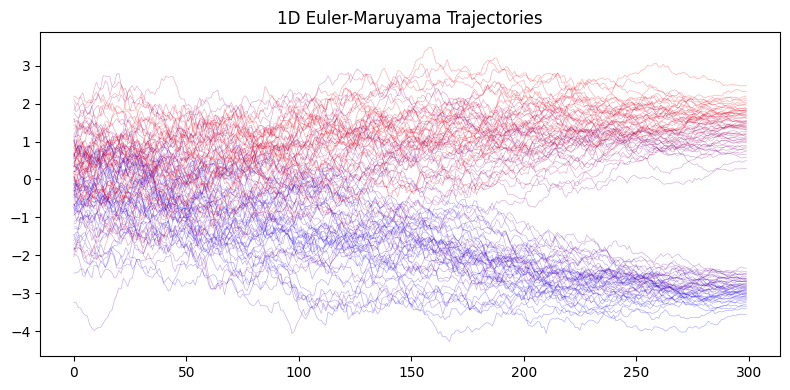

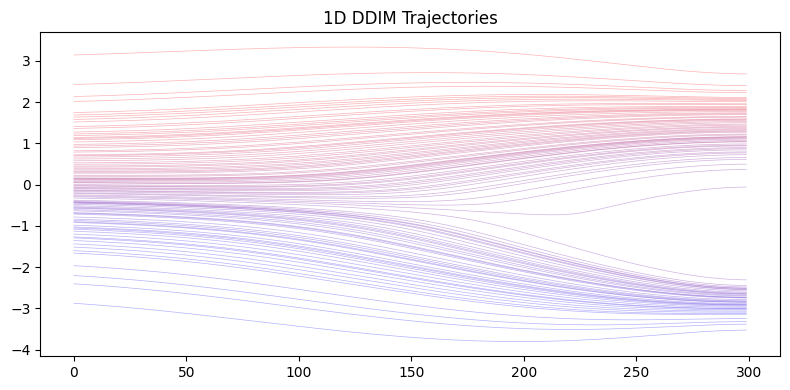

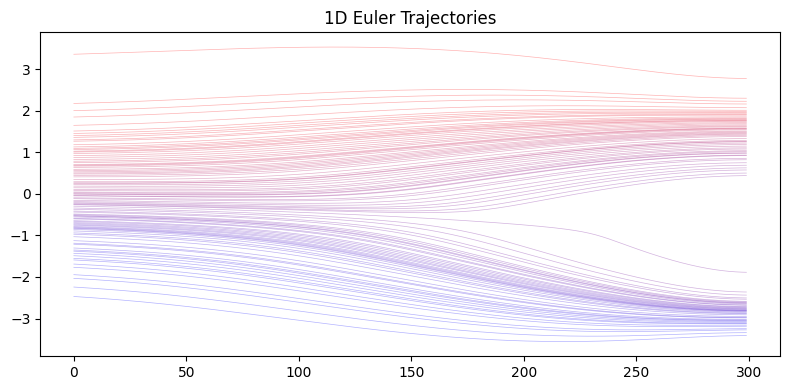

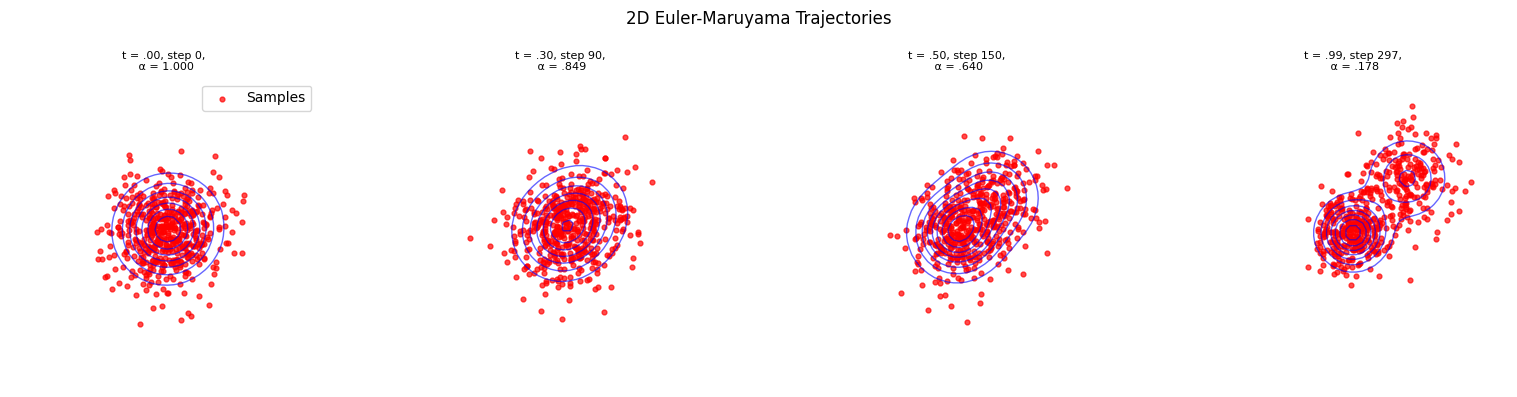

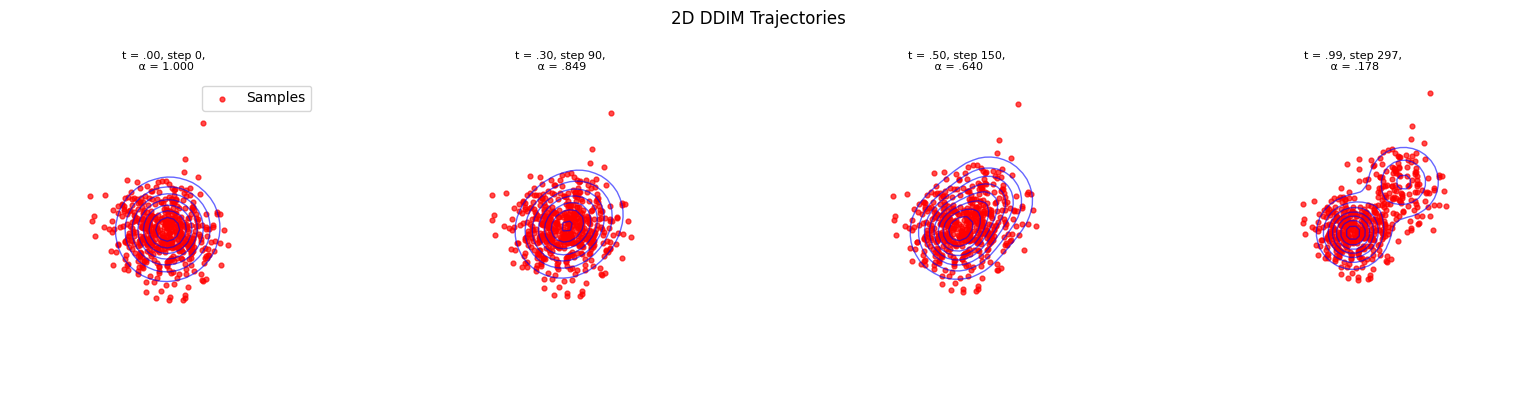

In [34]:
from diffuse.examples.gaussian_mixtures.plotting import display_trajectories
from diffuse.examples.gaussian_mixtures.plotting import display_2d_trajectories_at_times

# Create 1D trajectory plots using display_trajectories
fig = plt.figure(figsize=(8, 4))
display_trajectories(euler_m_hist_1d.squeeze(-1), 100, title="1D Euler-Maruyama Trajectories")
plt.tight_layout()
glue("traj_euler_m_1d", fig, display=False)
plt.show()

fig = plt.figure(figsize=(8, 4))
display_trajectories(ddim_hist_1d.squeeze(-1), 100, title="1D DDIM Trajectories")
plt.tight_layout()
glue("traj_ddim_1d", fig, display=False)
plt.show()

fig = plt.figure(figsize=(8, 4))
display_trajectories(euler_hist_1d.squeeze(-1), 100, title="1D Euler Trajectories")
plt.tight_layout()
glue("traj_euler_1d", fig, display=False)
plt.show()

# Create 2D trajectory plots
percentiles_2d = [0.0, 0.3, 0.5, 0.99]

# For 2D, display_2d_trajectories_at_times creates its own figure
display_2d_trajectories_at_times(
    euler_hist,
    timer,
    n_steps,
    percentiles_2d,
    lambda x, t: pdf_2d(x, 1.0 - t),
    sde=sde,
    title="2D Euler-Maruyama Trajectories",
)
fig = plt.gcf()  # Get the figure created by display_2d_trajectories_at_times
glue("traj_euler_m_2d", fig, display=False)
plt.show()

display_2d_trajectories_at_times(
    ddim_hist,
    timer,
    n_steps,
    percentiles_2d,
    lambda x, t: pdf_2d(x, 1.0 - t),
    sde=sde,
    title="2D DDIM Trajectories",
)
fig = plt.gcf()  # Get the figure created by display_2d_trajectories_at_times
glue("traj_ddim_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
### Euler-Maruyama
```{glue} traj_euler_m_1d
```

### DDIM
```{glue} traj_ddim_1d
```

### Euler
```{glue} traj_euler_1d
```
:::

:::{tab-item} 2D
### Euler-Maruyama
```{glue} traj_euler_m_2d
```

### DDIM
```{glue} traj_ddim_2d
```
:::

::::


## Conditional Generation

We demonstrate conditional generation for solving inverse problems of the form $x_0 \sim p(x_0|y)$ where $y$ is a measurement. We show two approaches:

1. **TMP(Tweedie's Moment Projection)**: Uses the forward model during sampling to guide generation
2. **Conditional Score**: Directly uses the posterior score function $\nabla_x \log p_t(x|y)$


### TMP Approach

TMP (Tweedie's Moment Projection) incorporates the measurement likelihood during the reverse diffusion process.

In [40]:
# Import conditional generation components
from diffuse.denoisers.cond import TMPDenoiser
from diffuse.base_forward_model import MeasurementState
from diffuse.examples.gaussian_mixtures.forward_models.matrix_product import MatrixProduct
from diffuse.examples.gaussian_mixtures.cond_mixture import compute_xt_given_y

forward_model_1d = MatrixProduct(A=A_1d, std=sigma_y_1d)
measurement_state_1d = MeasurementState(y=y_observed_1d, mask_history=A_1d)

# Create TMP denoiser for conditional generation
tmp_denoiser_1d = TMPDenoiser(
    integrator=euler_m_integrator,
    model=sde,
    predictor=predictor_1d,
    forward_model=forward_model_1d,
    x0_shape=(1,),
)

# Generate conditional samples
key_cond_1d = jax.random.PRNGKey(789)
cond_state_1d, cond_hist_1d = tmp_denoiser_1d.generate(
    key_cond_1d,
    measurement_state_1d,
    n_steps,
    n_samples,
    keep_history=True,
)

print(f"Generated {n_samples} 1D conditional samples using TMP")
print(f"1D Conditional samples x mean: {jnp.mean(cond_state_1d.integrator_state.position):.3f} (target: {y_observed_1d[0]})")


Generated 500 1D conditional samples using TMP
1D Conditional samples x mean: 0.737 (target: 0.5)


In [41]:

# 2D conditional generation setup
forward_model = MatrixProduct(A=A, std=sigma_y)
measurement_state = MeasurementState(y=y_observed, mask_history=A)

# Create TMP denoiser for 2D conditional generation
tmp_denoiser = TMPDenoiser(
    integrator=euler_m_integrator,
    model=sde,
    predictor=predictor_2d,
    forward_model=forward_model,
    x0_shape=(2,),
)

# Generate 2D conditional samples
key_cond = jax.random.PRNGKey(789)
cond_state, cond_hist = tmp_denoiser.generate(
    key_cond,
    measurement_state,
    n_steps,
    n_samples,
    keep_history=True,
)

print(f"Generated {n_samples} 2D conditional samples using TMP")
print(f"2D Conditional samples x₁ mean: {jnp.mean(cond_state.integrator_state.position[:, 0]):.3f} (target: {y_observed[0]})")

Generated 500 2D conditional samples using TMP
2D Conditional samples x₁ mean: 1.393 (target: 1.5)


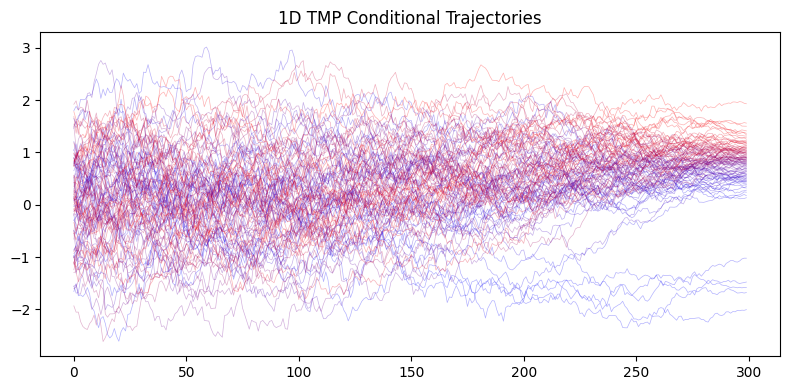

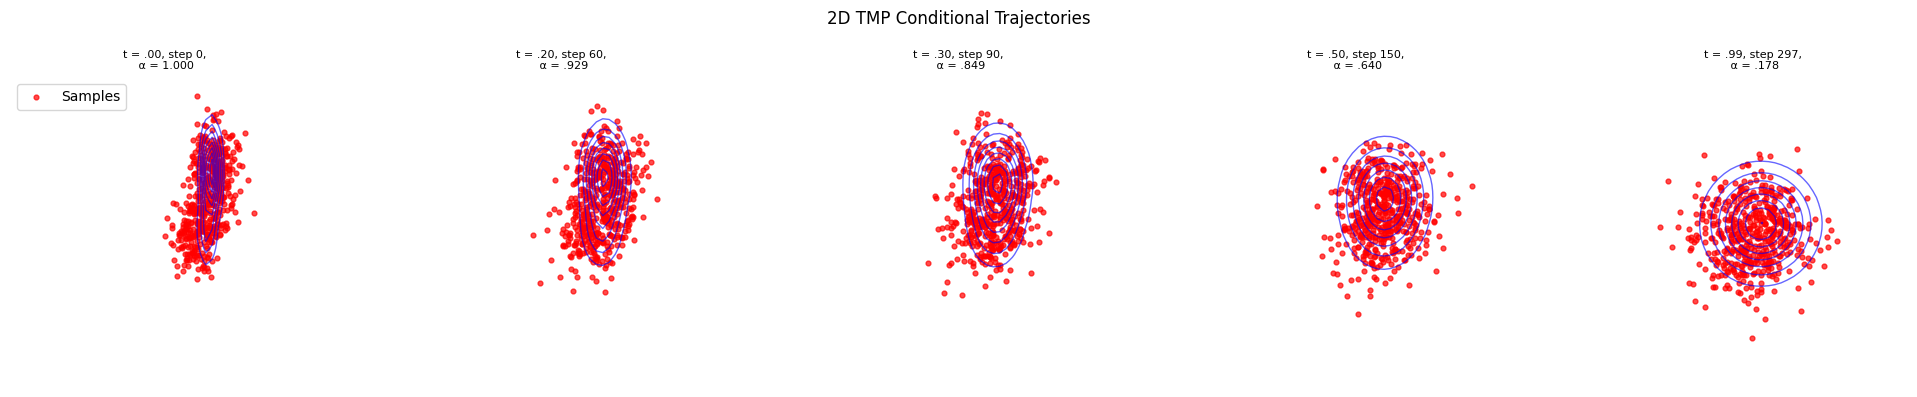

In [36]:
def conditional_pdf_1d(x, t):
    mix_state_t = compute_xt_given_y(posterior_state_1d, sde, t)
    return pdf_mixtr(mix_state_t, x)

def conditional_score_1d(x, t):
    return jax.grad(conditional_pdf_1d)(x, t) / conditional_pdf_1d(x, t)

def conditional_pdf(x, t):
    mix_state_t = compute_xt_given_y(posterior_state, sde, t)
    return pdf_mixtr(mix_state_t, x)

def conditional_score(x, t):
    return jax.grad(conditional_pdf)(x, t) / conditional_pdf(x, t)

# Create 1D TMP conditional trajectory plot
fig = plt.figure(figsize=(8, 4))
display_trajectories(cond_hist_1d.squeeze(-1), 100, title="1D TMP Conditional Trajectories")
plt.tight_layout()
glue("cond_traj_1d", fig, display=False)
plt.show()

# Create 2D TMP conditional trajectory plot
# display_2d_trajectories_at_times creates its own figure
display_2d_trajectories_at_times(
    cond_hist[::-1],
    timer,
    n_steps,
    [0.0, 0.2, 0.3, 0.5, 0.99],
    conditional_pdf,
    sde=sde,
    title="2D TMP Conditional Trajectories"
)
fig = plt.gcf()  # Get the figure created by display_2d_trajectories_at_times
glue("cond_traj_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
```{glue} cond_traj_1d
```
:::

:::{tab-item} 2D
```{glue} cond_traj_2d
```
:::

::::

### Conditional Score Approach

An alternative approach is to directly compute the posterior score function $\nabla_x \log p_t(x|y)$ in closed form (since we have analytical expressions for GMMs), and use it with standard sampling methods like DDIM.

In [37]:


# Create 1D predictor with conditional score
conditional_predictor_1d = Predictor(model=sde, network=conditional_score_1d, prediction_type="score")
denoiser_cond_score_1d = Denoiser(integrator=ddim_integrator, model=sde, predictor=conditional_predictor_1d, x0_shape=(1,))
cond_score_1d, cond_score_hist_1d = denoiser_cond_score_1d.generate(key_cond_1d, n_steps, n_samples, keep_history=True)

print(f"Generated {n_samples} 1D conditional samples using conditional score with DDIM")

# Create 2D predictor with conditional score
conditional_predictor = Predictor(model=sde, network=conditional_score, prediction_type="score")
denoiser_cond_score = Denoiser(integrator=ddim_integrator, model=sde, predictor=conditional_predictor, x0_shape=(2,))
cond_score, cond_score_hist = denoiser_cond_score.generate(key_cond, n_steps, n_samples, keep_history=True)

print(f"Generated {n_samples} 2D conditional samples using conditional score with DDIM")

Generated 500 1D conditional samples using conditional score with DDIM
Generated 500 2D conditional samples using conditional score with DDIM


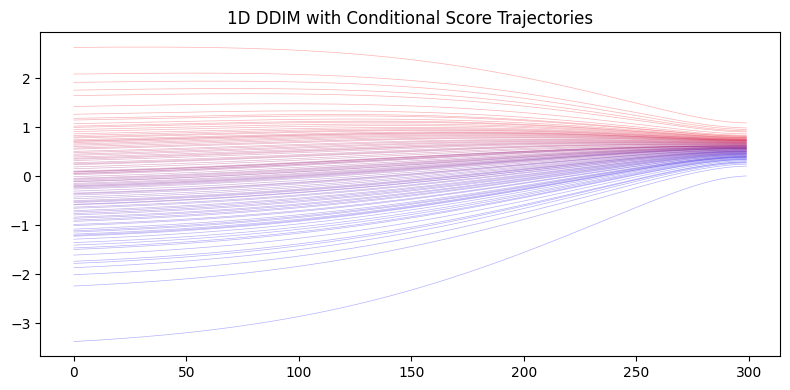

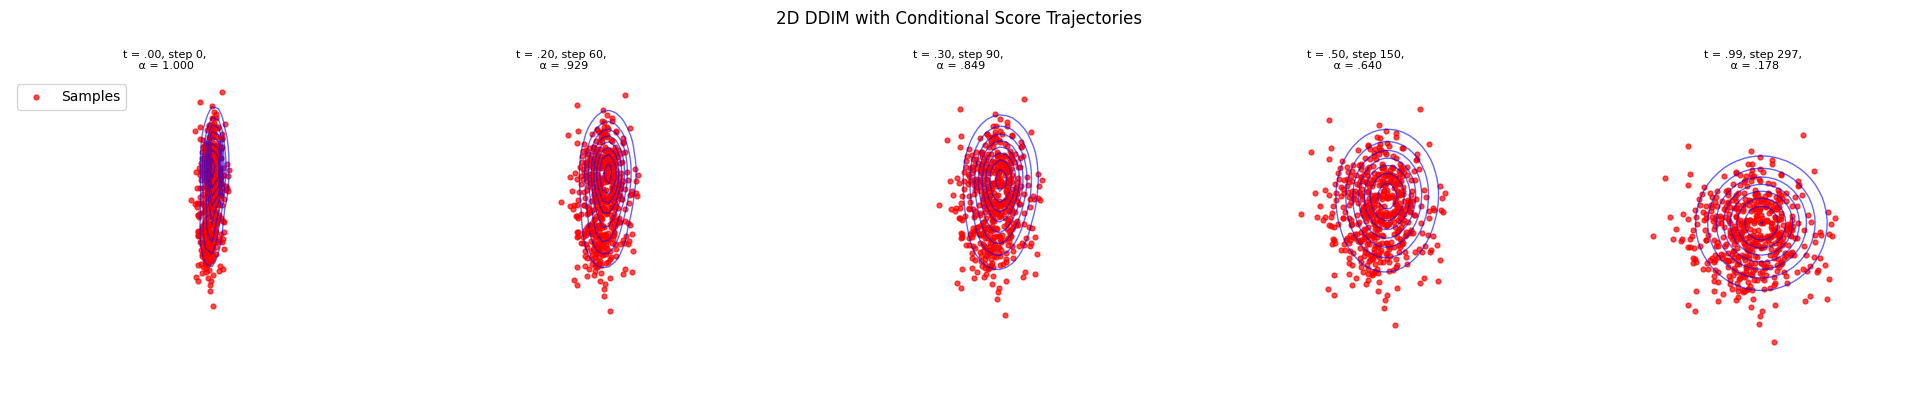

In [38]:
# Create 1D conditional score trajectory plot using display_trajectories
fig = plt.figure(figsize=(8, 4))
display_trajectories(cond_score_hist_1d.squeeze(-1), 100, title="1D DDIM with Conditional Score Trajectories")
plt.tight_layout()
glue("cond_score_traj_1d", fig, display=False)
plt.show()

# Create 2D conditional score trajectory plot
# display_2d_trajectories_at_times creates its own figure
display_2d_trajectories_at_times(
    cond_score_hist[::-1],
    timer,
    n_steps,
    [0.0, 0.2, 0.3, 0.5, 0.99],
    conditional_pdf,
    sde=sde,
    title="2D DDIM with Conditional Score Trajectories",
)
fig = plt.gcf()  # Get the figure created by display_2d_trajectories_at_times
glue("cond_score_traj_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
```{glue} cond_score_traj_1d
```
:::

:::{tab-item} 2D
```{glue} cond_score_traj_2d
```
:::

::::

## Stochastic Churn

Deterministic samplers such as **DDIM** or **Euler** can optionally be enhanced with *stochastic churning*, a mechanism that injects controlled noise at selected time steps to improve sample diversity and exploration. In this section, we explain how stochastic churn works and how it modifies the diffusion sampling process.

Stochastic churn proceeds in three steps:

1. **Compute a new noise level** based on the current time and churning schedule  
2. **Rescale the sample** according to the updated signal–noise ratio  
3. **Inject Gaussian noise** scaled by a user-defined factor  

The churn update is given by:

$$
x_{\text{churned}}
= \sqrt{\frac{\alpha_{\text{churned}}}{\alpha}}\, x
+ \sqrt{1 - \frac{\alpha_{\text{churned}}}{\alpha}} \;
  \varepsilon \cdot \text{noise\_factor},
$$

Where:
- $\alpha$ and $\alpha_{\text{churned}}$ come from the diffusion model’s noise schedule  
- $\varepsilon \sim \mathcal{N}(0, I)$ (standard Gaussian noise)  
- `noise_factor` scales the injected stochastic correction  

In the following, we illustrate how to apply stochastic churning during DDIM sampling and how different churn parameters affect sample trajectories.


Generated samples with 4 different churn configurations


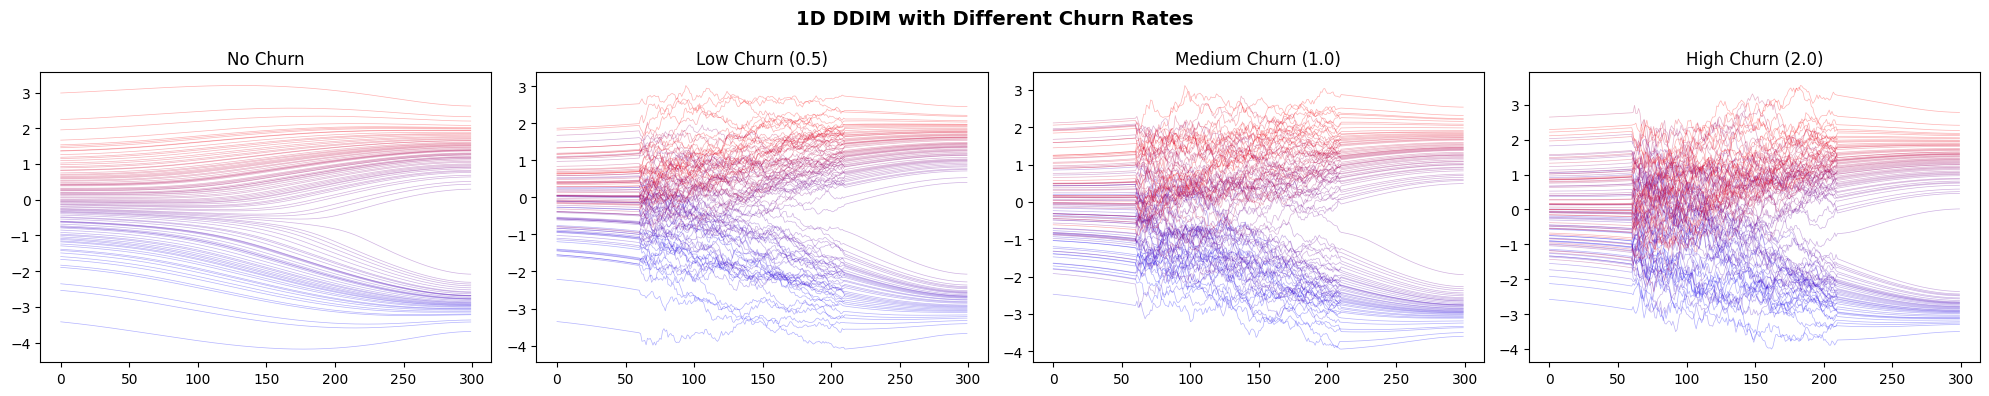

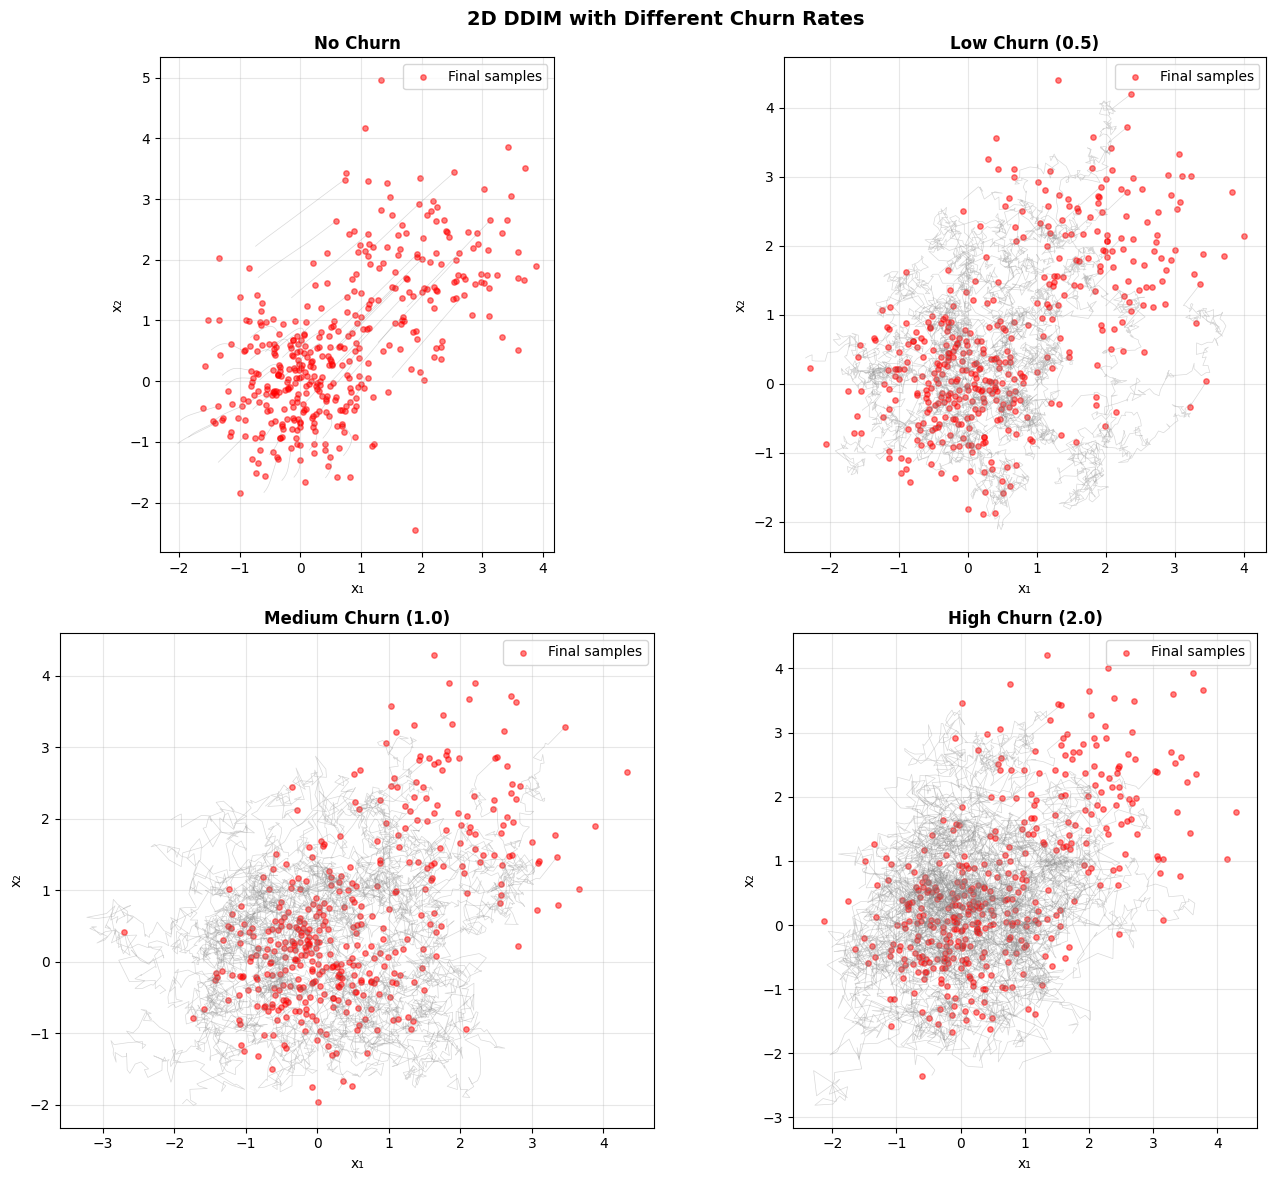

In [39]:
# Compare DDIM with different churning parameters
churn_configs = [
    {"rate": 0.0, "min": 0.0, "max": 1.0, "label": "No Churn"},
    {"rate": 0.5, "min": 0.3, "max": 0.8, "label": "Low Churn (0.5)"},
    {"rate": 1.0, "min": 0.3, "max": 0.8, "label": "Medium Churn (1.0)"},
    {"rate": 2.0, "min": 0.3, "max": 0.8, "label": "High Churn (2.0)"},
]

# Generate samples with different churn settings
churn_samples_1d = []
churn_samples_2d = []
churn_histories_1d = []
churn_histories_2d = []
key_churn = jax.random.PRNGKey(999)

for config in churn_configs:
    # Create integrator with churn
    ddim_churn = DDIMIntegrator(
        model=sde,
        timer=timer,
        stochastic_churn_rate=config["rate"],
        churn_min=config["min"],
        churn_max=config["max"],
    )

    # 1D denoiser
    denoiser_churn_1d = Denoiser(integrator=ddim_churn, model=sde, predictor=predictor_1d, x0_shape=(1,))

    # 2D denoiser
    denoiser_churn_2d = Denoiser(integrator=ddim_churn, model=sde, predictor=predictor_2d, x0_shape=(2,))

    # Generate samples
    key_churn, k1, k2 = jax.random.split(key_churn, 3)
    state_1d, history_1d = denoiser_churn_1d.generate(k1, n_steps, 400, keep_history=True)
    state_2d, history_2d = denoiser_churn_2d.generate(k2, n_steps, 400, keep_history=True)

    churn_samples_1d.append(state_1d.integrator_state.position)
    churn_samples_2d.append(state_2d.integrator_state.position)
    churn_histories_1d.append(history_1d)
    churn_histories_2d.append(history_2d)

print(f"Generated samples with {len(churn_configs)} different churn configurations")

# Plot all churn configurations
# 1D trajectories - plot all 4 configs side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle("1D DDIM with Different Churn Rates", fontsize=14, fontweight='bold')

for i, (history, config) in enumerate(zip(churn_histories_1d, churn_configs)):
    plt.sca(axes[i])
    display_trajectories(history.squeeze(-1), 100, title=config["label"])
    axes[i].set_title(config["label"], fontsize=12)

plt.tight_layout()
glue("churn_traj_1d", fig, display=False)
plt.show()

# 2D trajectories - plot all 4 configs in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("2D DDIM with Different Churn Rates", fontsize=14, fontweight='bold')
axes = axes.flatten()

for i, (history, config) in enumerate(zip(churn_histories_2d, churn_configs)):
    ax = axes[i]

    # Select a subset of trajectories to plot
    n_traj_to_plot = 50

    # Plot trajectories
    for j in range(min(n_traj_to_plot, history.shape[1])):
        traj = history[:, j, :]
        ax.plot(traj[:, 0], traj[:, 1], alpha=0.3, linewidth=0.5, color='gray')

    # Plot endpoints
    ax.scatter(history[-1, :, 0], history[-1, :, 1], alpha=0.5, s=15, c='red', label='Final samples')

    ax.set_title(config["label"], fontsize=12, fontweight='bold')
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal")
    ax.legend()

plt.tight_layout()
glue("churn_traj_2d", fig, display=False)
plt.show()

::::{tab-set}

:::{tab-item} 1D
```{glue} churn_traj_1d
```
:::

:::{tab-item} 2D
```{glue} churn_traj_2d
```
:::

::::